## **Pre-procesamiento de imágenes del dataset**

#### Para pre-procesar el dataset realizaremos lo siguiente:

1. Identificar y eliminar imágenes "faltantes" (corruptas/inaccesibles).

2. Identificar y eliminar imágenes duplicadas.

3. Identificar y descartar imágenes que tienen contraste y brillo atípico.

4. Identificar y descartar imágenes con dimensiones atípicas. 

5. Identificar y descartar imágenes con resoluciones muy altas y/o bajas. 

6. Redimensionar las imágenes a un estándar basado en la dimensión y resolución promedio. 

7. Balancear las imágenes.

8. Normalizar las imágenes.

***

In [88]:
# Librerías
import cv2
import os
import pandas as pd
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shutil
import random

In [81]:
# Directorios
Original_Images = "D:/IA/Original_Images"
Contrast_Brightness_Filtered = "D:/IA/Contrast_Brightness_Filtered"
Dimension_Filtered = "D:/IA/Dimension_Filtered"
Resolution_Filtered = "D:/IA/Resolution_Filtered"
Resized_Images = "D:/IA/Resized_Images"
Balanced_Images = "D:/IA/Balanced_Images"
Normalized_Images = "D:/IA/Normalized_Images"
folders = ['BigTruck', 'CityCar', 'MultiPurposeVehicle', 'Sedan', 'SportUtilityVehicle', 'Truck', 'Van']

In [ ]:
def contar_imagenes(folder):
    """Cuenta la cantidad de imágenes en cada subcarpeta dentro de la carpeta base."""
    conteo_imagenes = {}
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            imagenes = [f for f in os.listdir(subfolder_path)]
            conteo_imagenes[subfolder] = len(imagenes)  
    return conteo_imagenes

***

### **1. Identificar y eliminar imagenes faltantes**

#### Si el dataset contiene imágenes corruptas o inaccesibles, que no se pueden abrir, las eliminamos. 

In [5]:
def verificar_imagenes_corruptas_inaccesibles(folder_path):
    imagenes_validas = []
    imagenes_corruptas = []
    
    # Recorremos todas las imágenes en la carpeta
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            # Intentamos cargar la imagen
            try:
                img = cv2.imread(file_path)
                if img is None:  # Si no se puede cargar, es corrupta
                    imagenes_corruptas.append(file_path)
                else:
                    imagenes_validas.append(file_path)
            except Exception as e:
                print(f"Error al procesar {file_path}: {e}")
                imagenes_corruptas.append(file_path) 
    # Eliminamos las imágenes corruptas
    for img_corrupta in imagenes_corruptas:
        os.remove(img_corrupta)
        print(f"Imagen corrupta eliminada: {img_corrupta}")
    return imagenes_validas, imagenes_corruptas

In [6]:
resultados = []

for folder in folders:
    folder_path = os.path.join(Original_Images, folder)
    validas, corruptas = verificar_imagenes_corruptas_inaccesibles(folder_path)
    resultados.append([folder, len(validas), len(corruptas)])
    
# Mostrar tabla con resultados
df_resultados = pd.DataFrame(resultados, columns=['Clase', 'Imágenes Válidas', 'Imágenes Corruptas'])
df_resultados

,Clase,Imágenes Válidas,Imágenes Corruptas
0,BigTruck,577,0
1,CityCar,4657,0
2,MultiPurposeVehicle,2649,0
3,Sedan,2619,0
4,SportUtilityVehicle,1826,0
5,Truck,1150,0
6,Van,2167,0


#### Vemos que todas las imágenes son accesibles, por lo que no tuvimos que eliminar ninguna. 

***


### **2. Identificar y eliminar imagenes duplicadas**

#### Si el dataset contiene imágenes duplicadas, las eliminamos. Para ello obtendremos el Hash de cada imágen, y los compararemos entre sí para reconocer duplicados. 

In [8]:
def generar_hash_imagen(img_path):
    hash_md5 = hashlib.md5()
    with open(img_path, 'rb') as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            hash_md5.update(byte_block)
    return hash_md5.hexdigest()

In [9]:
def eliminar_duplicados(duplicados):
    for img_path in duplicados:
        print(f"Eliminando duplicado: {img_path}")
        os.remove(img_path)

In [10]:
def detectar_duplicados(folder_paths):
    hashes = {}
    duplicados = []
    # Recorremos las imágenes dentro de las carpetas
    for folder_path in folder_paths:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(root, file)
                    img_hash = generar_hash_imagen(file_path)
                    # Si el hash ya existe, es un duplicado
                    if img_hash in hashes:
                        duplicados.append(file_path)
                    else:
                        hashes[img_hash] = file_path                       
    if duplicados:
        print("Imágenes duplicadas encontradas:")
        for img_path in duplicados:
            print(f"  - {img_path}")
    else:
        print("No se encontraron imágenes duplicadas.")

    eliminar_duplicados(duplicados)

In [11]:
folder_paths = [os.path.join(Original_Images, folder) for folder in folders]
detectar_duplicados(folder_paths)

No se encontraron imágenes duplicadas.


#### Ya que ningún duplicado fue encontrado, no se elimina ninguna imagen.

***

### **3. Identificar y descartar imágenes que tienen contraste y brillo atípico.**

##### *3.1 Histograma de intensidad para identificar valores atípicos de contraste y brillo* 

In [13]:
def obtener_brillo_contraste(imagen):
    img_gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    brillo = np.mean(img_gray)
    contraste = np.std(img_gray)
    return brillo, contraste

In [15]:
def generar_histograma_intensidad_con_outliers(brillos, contrastes):
    """Genera un histograma de brillo y contraste para todas las imágenes."""
    global limite_inferior_brillo, limite_superior_brillo, limite_inferior_contraste, limite_superior_contraste
    
    # Calcular la media y desviación estándar de los datos
    media_brillo = np.mean(brillos)
    desviacion_brillo = np.std(brillos)
    media_contraste = np.mean(contrastes)
    desviacion_contraste = np.std(contrastes)
    
    # Límites para detectar outliers
    limite_inferior_brillo = media_brillo - 2 * desviacion_brillo
    limite_superior_brillo = media_brillo + 2 * desviacion_brillo
    
    limite_inferior_contraste = media_contraste - 2 * desviacion_contraste
    limite_superior_contraste = media_contraste + 2 * desviacion_contraste
    
    # Histograma de brillo
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(brillos, bins=50, color='lightblue', edgecolor='black')
    plt.title('Histograma de Brillo')
    plt.xlabel('Valor de brillo')
    plt.ylabel('Frecuencia')
    plt.axvline(limite_inferior_brillo, color='red', linestyle='dashed', linewidth=2, label='Límite Inferior')
    plt.axvline(limite_superior_brillo, color='red', linestyle='dashed', linewidth=2, label='Límite Superior')
    
    # Histograma de contraste
    plt.subplot(1, 2, 2)
    plt.hist(contrastes, bins=50, color='lightcoral', edgecolor='black')
    plt.title('Histograma de Contraste')
    plt.xlabel('Valor de contraste')
    plt.ylabel('Frecuencia')
    plt.axvline(limite_inferior_contraste, color='red', linestyle='dashed', linewidth=2, label='Límite Inferior')
    plt.axvline(limite_superior_contraste, color='red', linestyle='dashed', linewidth=2, label='Límite Superior')
    
    plt.tight_layout()
    plt.legend()
    plt.show()

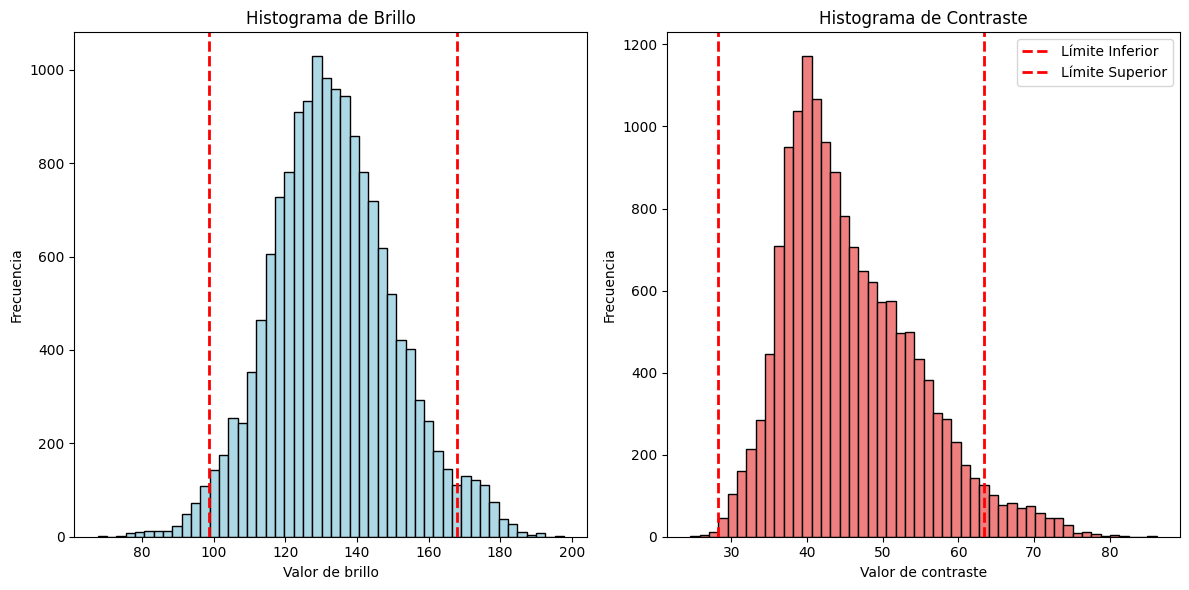

In [16]:
# Listas para almacenar los valores globales de brillo y contraste
brillos_totales = []
contrastes_totales = []

# Obtener brillo y contraste de todas las imágenes
for folder in folders:
    folder_path = os.path.join(Original_Images, folder)
    imagenes = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_path in imagenes:
        img = cv2.imread(img_path)
        brillo, contraste = obtener_brillo_contraste(img)
        if brillo is not None and contraste is not None:
            brillos_totales.append(brillo)
            contrastes_totales.append(contraste)

# Generar el histograma y calcular límites de outliers
generar_histograma_intensidad_con_outliers(brillos_totales, contrastes_totales)

##### *3.2 Descartar imágenes con valores atípicos de contraste y brillo* 

In [18]:
def copiar_imagenes_filtradas_brillo_contraste():
    """Copia las imágenes que no tienen valores de brillo y/o contraste atípico
      a una nueva carpeta manteniendo la estructura de subcarpetas."""
    for folder in folders:
        source_folder = os.path.join(Original_Images, folder)
        dest_folder = os.path.join(Contrast_Brightness_Filtered, folder)

        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        imagenes = [f for f in os.listdir(source_folder)]
        
        for img_name in imagenes:
            img_path = os.path.join(source_folder, img_name)
            img = cv2.imread(img_path)            
            
            brillo, contraste = obtener_brillo_contraste(img)
            
            if (limite_inferior_brillo <= brillo <= limite_superior_brillo) and (limite_inferior_contraste <= contraste <= limite_superior_contraste):
                shutil.copy(img_path, os.path.join(dest_folder, img_name))

copiar_imagenes_filtradas_brillo_contraste()

In [46]:
# Número de imágenes después de descartar aquellas con brillo y contraste extremos
original_counts = contar_imagenes(Original_Images)
processed_counts = contar_imagenes(Contrast_Brightness_Filtered)
    
df = pd.DataFrame({
    "Clase": list(original_counts.keys()),
    "Originales": [original_counts.get(clase, 0) for clase in original_counts],
    "Procesadas con brillo y contraste": [processed_counts.get(clase, 0) for clase in original_counts]
})  
df.loc['Total'] = df.sum(numeric_only=True)
df.loc['Total', 'Clase'] = 'Total'
df

,Clase,Originales,Procesadas con brillo y contraste
0,BigTruck,577.0,456.0
1,CityCar,4657.0,4337.0
2,MultiPurposeVehicle,2649.0,2470.0
3,Sedan,2619.0,2403.0
4,SportUtilityVehicle,1826.0,1649.0
5,Truck,1150.0,969.0
6,Van,2167.0,1818.0
Total,Total,15645.0,14102.0


In [24]:
def visualizar_histograma_brillo_contraste_actual(brillos, contrastes):
    """Genera un histograma general de brillo y contraste para todas las imágenes."""

    # Histograma de brillo
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(brillos, bins=50, color='lightblue', edgecolor='black')
    plt.title('Histograma de Brillo si valores atípicos')
    plt.xlabel('Valor de brillo')
    plt.ylabel('Frecuencia')
    
    # Histograma de contraste
    plt.subplot(1, 2, 2)
    plt.hist(contrastes, bins=50, color='lightcoral', edgecolor='black')
    plt.title('Histograma de Contraste sin valores atípicos')
    plt.xlabel('Valor de contraste')
    plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

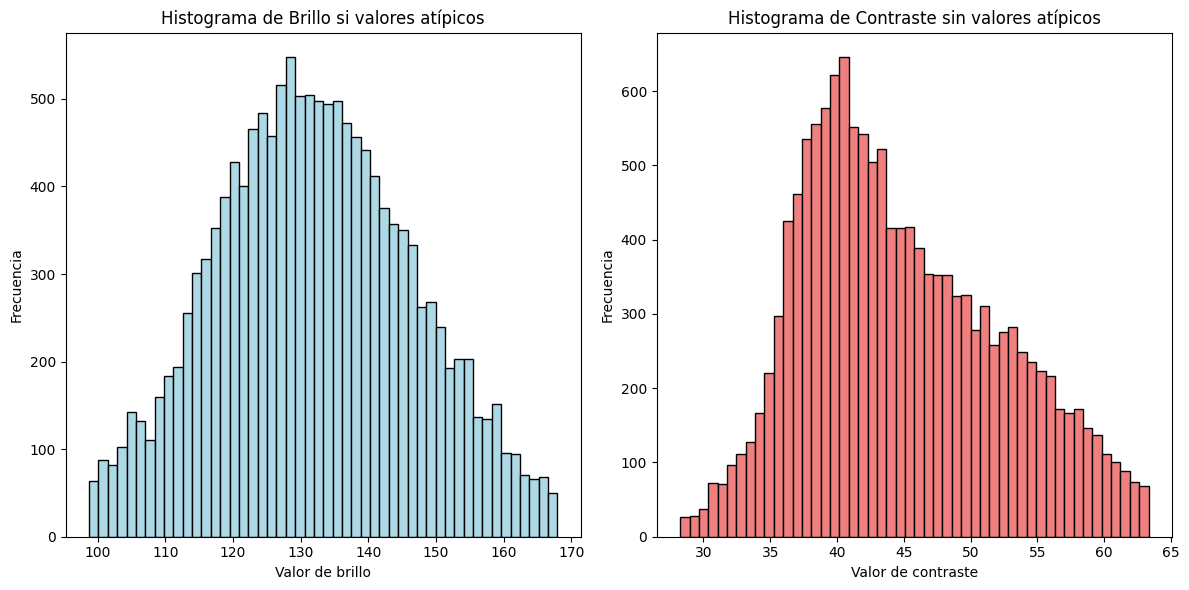

In [25]:
# Listas para almacenar los valores globales de brillo y contraste
brillos_totales = []
contrastes_totales = []

# Obtener brillo y contraste de todas las imágenes
for folder in folders:
    folder_path = os.path.join(Contrast_Brightness_Filtered, folder)
    imagenes = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_path in imagenes:
        img = cv2.imread(img_path)
        brillo, contraste = obtener_brillo_contraste(img)
        if brillo is not None and contraste is not None:
            brillos_totales.append(brillo)
            contrastes_totales.append(contraste)

# Generar el histograma y calcular límites de outliers
visualizar_histograma_brillo_contraste_actual(brillos_totales, contrastes_totales)

***

### **4. Identificar y descartar imágenes con dimensiones atípicas.**

##### *4.1 Boxplot de dimensiones para identificar dimensiones atípicas*

In [26]:
def obtener_dimensiones(imagen):
    """Obtiene las dimensiones (alto, ancho) de la imagen."""
    alto, ancho = imagen.shape[:2] 
    return alto, ancho

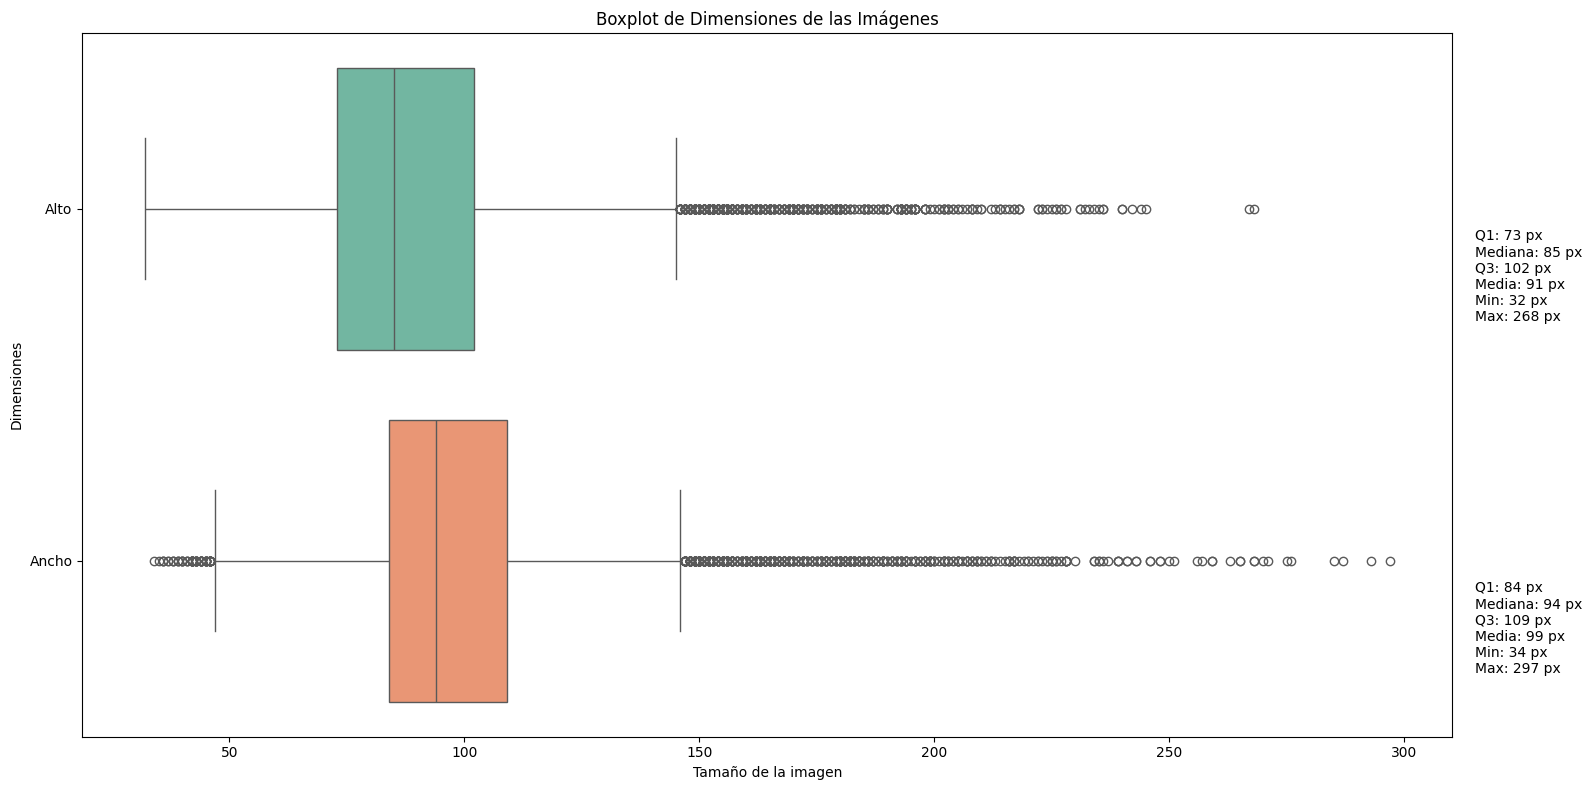

In [41]:
def visualizar_boxplot_dimensiones(images, coordenada):
    """Genera un boxplot para las dimensiones (alto y ancho) y muestra las estadísticas relevantes."""
    dimensiones_altos = []
    dimensiones_anchos = []

    # Iterar sobre cada carpeta
    for folder in folders:
        folder_path = os.path.join(images, folder)
        imagenes = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Obtener las dimensiones de cada imagen
        for img_path in imagenes:
            img = cv2.imread(img_path)
            alto, ancho = obtener_dimensiones(img)
            dimensiones_altos.append(alto)
            dimensiones_anchos.append(ancho)

    # Crear un DataFrame para trabajar con seaborn
    data = pd.DataFrame({
        'Alto': dimensiones_altos,
        'Ancho': dimensiones_anchos
    })

    # Calcular estadísticas
    stats = data.describe().transpose()

    # Crear el boxplot de Seaborn
    plt.figure(figsize=(16, 8))
    
    # Boxplot de las dimensiones
    sns.boxplot(data=data, orient='h', palette="Set2")
    plt.title('Boxplot de Dimensiones de las Imágenes')
    plt.xlabel('Tamaño de la imagen')
    plt.ylabel('Dimensiones')

    # Imprimir estadísticas clave en las cajas al lado de los boxplots
    for i, dimension in enumerate(['Alto', 'Ancho']):
        # Coordenadas para colocar el texto
        x_pos = coordenada
        y_pos = i + 0.1 
        
        # Establecer el texto de la estadística
        box_stats = f"Q1: {stats.loc[dimension, '25%']:.0f} px\n" + \
                    f"Mediana: {stats.loc[dimension, '50%']:.0f} px\n" + \
                    f"Q3: {stats.loc[dimension, '75%']:.0f} px\n" + \
                    f"Media: {stats.loc[dimension, 'mean']:.0f} px\n" + \
                    f"Min: {stats.loc[dimension, 'min']:.0f} px\n" + \
                    f"Max: {stats.loc[dimension, 'max']:.0f} px"

        
        # Dibujar el texto dentro de un rectángulo (caja)
        plt.gca().add_patch(plt.Rectangle((x_pos, y_pos), 0.2, 0.4, color="white", ec="black", lw=1))  # Caja
        plt.text(x_pos + 0.01, y_pos + 0.22, box_stats, fontsize=10, color="black", ha='left')  # Texto dentro de la caja

    plt.tight_layout()
    plt.show()

visualizar_boxplot_dimensiones(Contrast_Brightness_Filtered, coordenada=315)

##### *4.2 Se descartan imágenes con dimensiones atípicas*

In [35]:
def copiar_imagenes_filtradas_dimensiones():
    """Copia las imágenes que no tienen dimensiones atípicas a una nueva carpeta 
    manteniendo la estructura de subcarpetas."""
    
    # Definir límites para las dimensiones atípicas basados en los cuartiles
    global limite_inferior_alto, limite_superior_alto, limite_inferior_ancho, limite_superior_ancho

    # Obtener las dimensiones de todas las imágenes
    dimensiones_altos = []
    dimensiones_anchos = []

    for folder in folders:
        folder_path = os.path.join(Contrast_Brightness_Filtered, folder)
        imagenes = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for img_path in imagenes:
            img = cv2.imread(img_path)
            alto, ancho = obtener_dimensiones(img)
            dimensiones_altos.append(alto)
            dimensiones_anchos.append(ancho)

    # Calcular los cuartiles y el rango intercuartílico (IQR)
    q1_alto = np.percentile(dimensiones_altos, 25)
    q3_alto = np.percentile(dimensiones_altos, 75)
    iqr_alto = q3_alto - q1_alto

    q1_ancho = np.percentile(dimensiones_anchos, 25)
    q3_ancho = np.percentile(dimensiones_anchos, 75)
    iqr_ancho = q3_ancho - q1_ancho

    # Establecer límites de los valores atípicos (usando 1.5 * IQR)
    limite_inferior_alto = q1_alto - 1.5 * iqr_alto
    limite_superior_alto = q3_alto + 1.5 * iqr_alto
    limite_inferior_ancho = q1_ancho - 1.5 * iqr_ancho
    limite_superior_ancho = q3_ancho + 1.5 * iqr_ancho

    # Copiar las imágenes que no son atípicas a la nueva carpeta
    for folder in folders:
        source_folder = os.path.join(Contrast_Brightness_Filtered, folder)
        dest_folder = os.path.join(Dimension_Filtered, folder)

        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        imagenes = [f for f in os.listdir(source_folder)]
        
        for img_name in imagenes:
            img_path = os.path.join(source_folder, img_name)
            img = cv2.imread(img_path)
            alto, ancho = obtener_dimensiones(img)
            
            if (limite_inferior_alto <= alto <= limite_superior_alto) and (limite_inferior_ancho <= ancho <= limite_superior_ancho):
                shutil.copy(img_path, os.path.join(dest_folder, img_name))

copiar_imagenes_filtradas_dimensiones()

In [45]:
# Número de imágenes después de descartar aquellas con dimensiones atípicas
original_counts = contar_imagenes(Contrast_Brightness_Filtered)
processed_counts = contar_imagenes(Dimension_Filtered)
    
df = pd.DataFrame({
    "Clase": list(original_counts.keys()),
    "Procesadas con brillo y contraste": [original_counts.get(clase, 0) for clase in original_counts],
    "Procesadas dimensiones": [processed_counts.get(clase, 0) for clase in original_counts]
})  

df.loc['Total'] = df.sum(numeric_only=True)
df.loc['Total', 'Clase'] = 'Total'

df

,Clase,Procesadas con brillo y contraste,Procesadas dimensiones
0,BigTruck,456.0,242.0
1,CityCar,4337.0,4309.0
2,MultiPurposeVehicle,2470.0,2452.0
3,Sedan,2403.0,2392.0
4,SportUtilityVehicle,1649.0,1617.0
5,Truck,969.0,672.0
6,Van,1818.0,1637.0
Total,Total,14102.0,13321.0


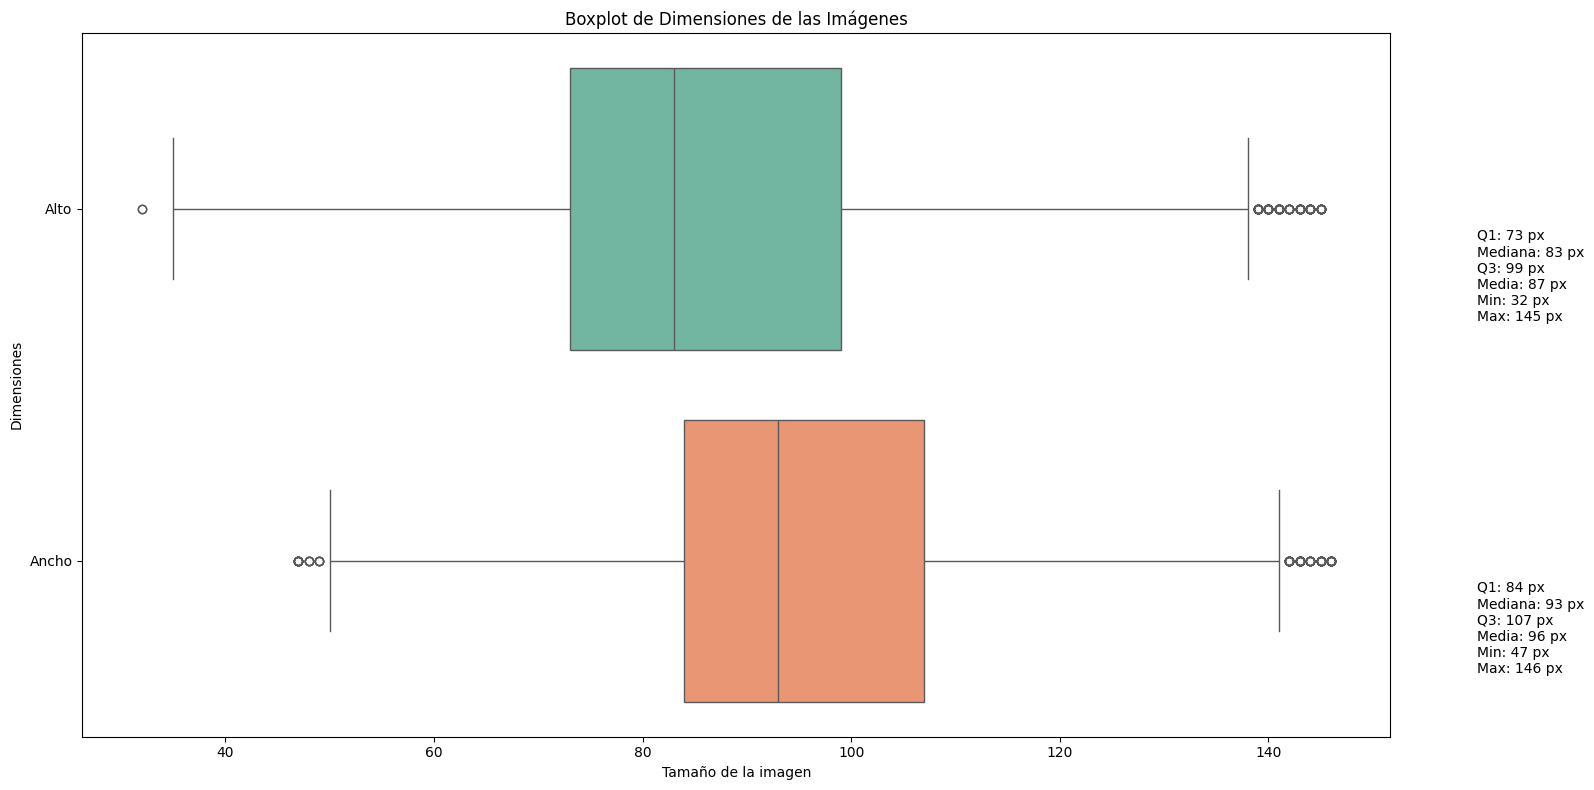

In [43]:
visualizar_boxplot_dimensiones(Dimension_Filtered, coordenada=160)

***

### **5. Identificar y descartar imágenes con resoluciones muy altas y/o bajas.** 

##### *5.1 Histograma de resolución de imágenes para identificar imágenes con baja o alta resolución*

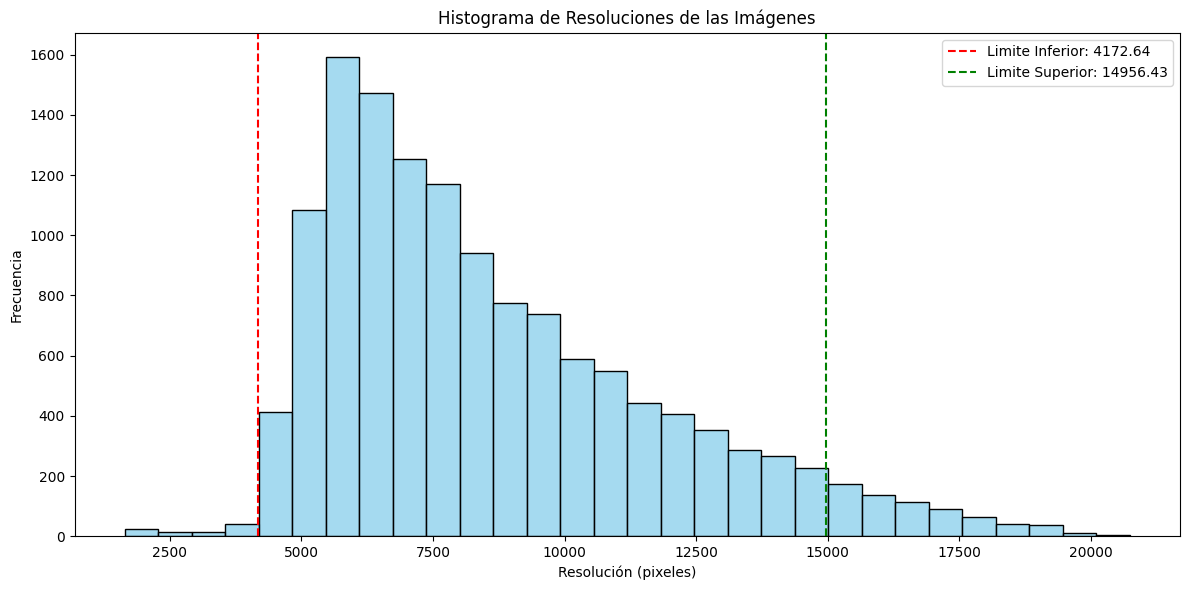

In [66]:
def visualizar_histograma_resoluciones(folders):
    """Genera un histograma de las resoluciones de las imágenes y 
    define los límites globales para valores atípicos."""
    global limite_inferior, limite_superior  # Permite modificar las variables globales
    resoluciones = []

    # Iterar sobre cada carpeta (clase)
    for folder in folders:
        folder_path = os.path.join(Dimension_Filtered, folder)
        imagenes = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Obtener las resoluciones de cada imagen
        for img_path in imagenes:
            img = cv2.imread(img_path)
            if img is None:
                continue
            alto, ancho = obtener_dimensiones(img)
            resoluciones.append(alto * ancho)  # Se usa el área de la imagen como resolución

    # Calcular estadísticas: media y desviación estándar
    media = np.mean(resoluciones)
    desviacion_estandar = np.std(resoluciones)
    
    # Definir los límites globales
    limite_inferior = media - 1.4 * desviacion_estandar
    limite_superior = media + 2 * desviacion_estandar

    # Crear el histograma
    plt.figure(figsize=(12, 6))
    sns.histplot(resoluciones,  bins=30, color='skyblue')

    # Añadir las líneas para los outliers
    plt.axvline(limite_inferior, color='red', linestyle='--', label=f'Limite Inferior: {limite_inferior:.2f}')
    plt.axvline(limite_superior, color='green', linestyle='--', label=f'Limite Superior: {limite_superior:.2f}')

    # Etiquetas y título
    plt.title('Histograma de Resoluciones de las Imágenes')
    plt.xlabel('Resolución (pixeles)')
    plt.ylabel('Frecuencia')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualizar_histograma_resoluciones(folders)

##### *5.2 Se descartan imágenes con resoluciones muy bajas o muy altas*

In [ ]:
def copiar_imagenes_por_resolucion(folders):
    """Copia imágenes cuya resolución esté dentro de los límites a Resolution_Filtered."""

    for folder in folders:
        source_folder = os.path.join(Dimension_Filtered, folder)
        dest_folder = os.path.join(Resolution_Filtered, folder)

        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        imagenes = [f for f in os.listdir(source_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for img_name in imagenes:
            img_path = os.path.join(source_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            alto, ancho = obtener_dimensiones(img)
            resolucion = alto * ancho

            # Verificar si la resolución está dentro de los límites
            if limite_inferior <= resolucion <= limite_superior:
                dest_img_path = os.path.join(dest_folder, img_name)

                if img_path != dest_img_path:  # Evitar copiar sobre sí mismo
                    shutil.copy(img_path, dest_folder)

copiar_imagenes_por_resolucion(folders)

In [68]:
# Número de imágenes después de descartar aquellas con resolución atípica
original_counts = contar_imagenes(Dimension_Filtered)
processed_counts = contar_imagenes(Resolution_Filtered)
    
df = pd.DataFrame({
    "Clase": list(original_counts.keys()),
    "Procesadas dimensiones": [original_counts.get(clase, 0) for clase in original_counts],
    "Procesadas resolución": [processed_counts.get(clase, 0) for clase in original_counts]
})  

df.loc['Total'] = df.sum(numeric_only=True)
df.loc['Total', 'Clase'] = 'Total'

df

,Clase,Procesadas dimensiones,Procesadas resolución
0,BigTruck,242.0,186.0
1,CityCar,4309.0,4196.0
2,MultiPurposeVehicle,2452.0,2335.0
3,Sedan,2392.0,2308.0
4,SportUtilityVehicle,1617.0,1499.0
5,Truck,672.0,536.0
6,Van,1637.0,1469.0
Total,Total,13321.0,12529.0


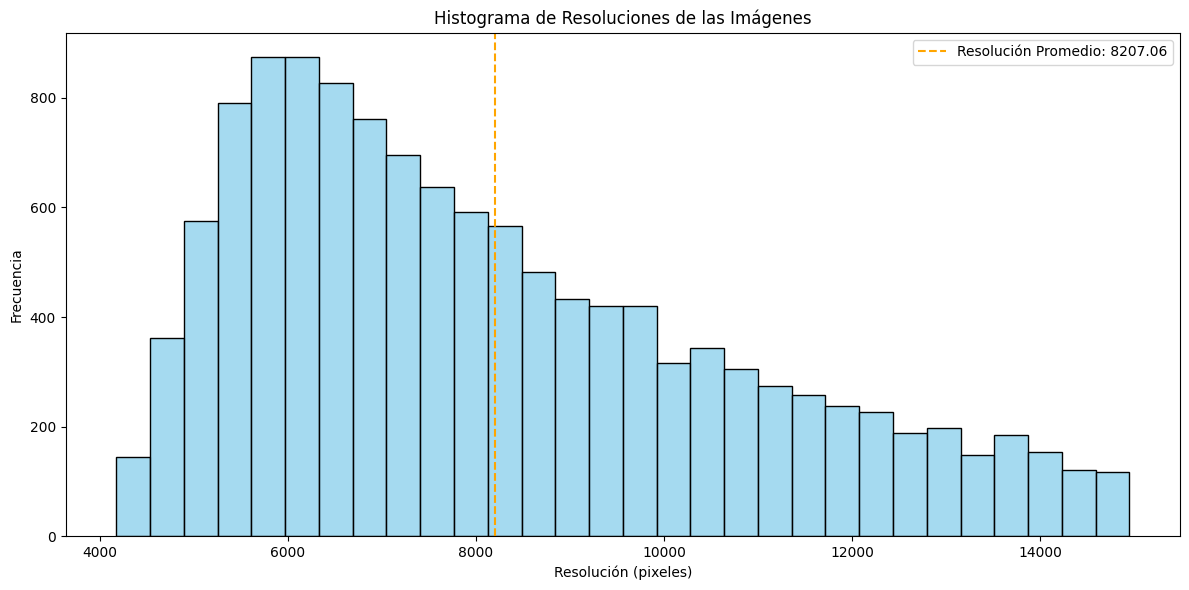

In [76]:
def visualizar_histograma_resoluciones_sin_outliers(folders):
    """Genera un histograma de las resoluciones de las imágenes"""
   
    resoluciones = []

    # Iterar sobre cada carpeta (clase)
    for folder in folders:
        folder_path = os.path.join(Resolution_Filtered, folder)
        imagenes = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Obtener las resoluciones de cada imagen
        for img_path in imagenes:
            img = cv2.imread(img_path)
            if img is None:
                continue
            alto, ancho = obtener_dimensiones(img)
            resoluciones.append(alto * ancho)  # Se usa el área de la imagen como resolución

    media = np.mean(resoluciones)
    # Crear el histograma
    plt.figure(figsize=(12, 6))
    sns.histplot(resoluciones,  bins=30, color='skyblue')

    plt.axvline(media, color='orange', linestyle='--', label=f'Resolución Promedio: {media:.2f}')
    # Etiquetas y título
    plt.title('Histograma de Resoluciones de las Imágenes')
    plt.xlabel('Resolución (pixeles)')
    plt.ylabel('Frecuencia')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualizar_histograma_resoluciones_sin_outliers(folders)

***

### **6. Redimensionar las imágenes a un estándar**

*Considerando la mediana de 83x93 píxeles y la resolución promedio de 8200 píxeles, se decidió redimensionar las imágenes a 88x96 píxeles. Este tamaño se acerca a la mediana y mantiene la resolución promedio*

In [79]:
NUEVO_ANCHO = 96
NUEVO_ALTO = 88

def redimensionar_imagenes(folders):
    """ Redimensiona las imágenes de cada clase a 88x96 píxeles y las guarda en una nueva carpeta. """
    for folder in folders:
        src_folder = os.path.join(Resolution_Filtered, folder)
        dest_folder = os.path.join(Resized_Images, folder)
        
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        # Obtener todas las imágenes del directorio
        imagenes = [f for f in os.listdir(src_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for img_name in imagenes:
            img_path = os.path.join(src_folder, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Redimensionar la imagen
                img_resized = cv2.resize(img, (NUEVO_ANCHO, NUEVO_ALTO), interpolation=cv2.INTER_AREA)
                
                # Guardar la imagen redimensionada
                cv2.imwrite(os.path.join(dest_folder, img_name), img_resized)

redimensionar_imagenes(folders)

***

### **7. Balancear las clases**




#### *7.1 Se muestran imágenes antes de balancear*

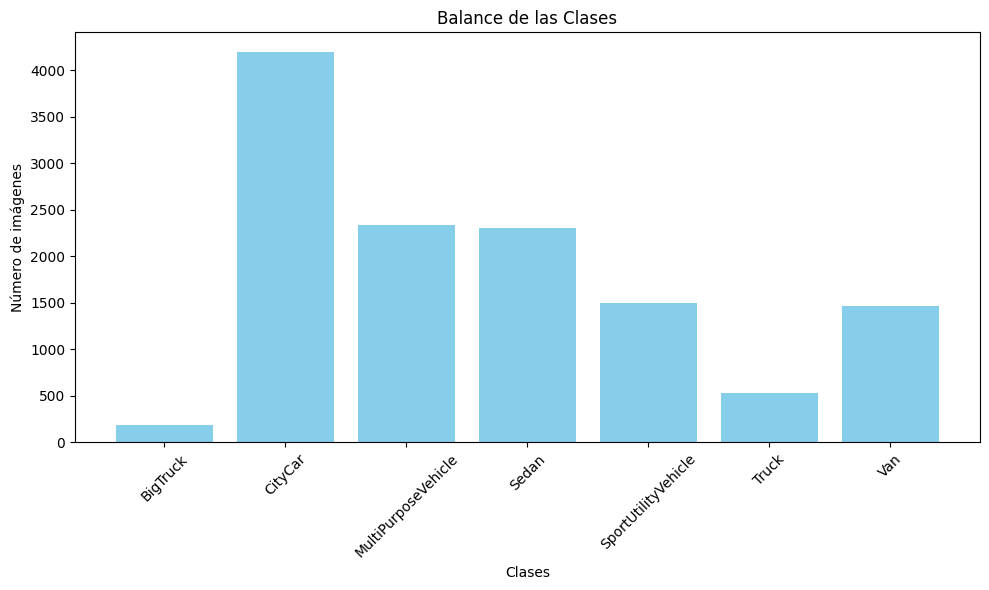

In [90]:
def graficar_balance_clases(dataset):
    """ Genera un gráfico de barras con el balance de las clases  """
    
    # Directorio de las clases balanceadas
    balanced_folder = dataset
    
    # Obtener los nombres de las clases
    clases = os.listdir(balanced_folder)
    
    # Contar el número de imágenes en cada clase
    counts = []
    for clase in clases:
        class_folder = os.path.join(balanced_folder, clase)
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        counts.append(num_images)

    # Graficar el balance de las clases
    plt.figure(figsize=(10, 6))
    plt.bar(clases, counts, color='skyblue')
    
    # Añadir etiquetas y título
    plt.xlabel('Clases')
    plt.ylabel('Número de imágenes')
    plt.title('Balance de las Clases')
    plt.xticks(rotation=45)  
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Llamar a la función para generar el gráfico
graficar_balance_clases(Resized_Images)

#### *Fusión de clases:* Se unirá **BigTruck** con **Truck** en una sola clase llamada **Truck**.

In [84]:
def unir_bigtruck_y_truck():
    """ Une las imágenes de BigTruck y Truck en una sola clase llamada Truck. """
    
    # Crear la carpeta destino para la clase Truck si no existe
    dest_folder = os.path.join(Balanced_Images, 'Truck')
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Directorios de las clases a unir
    src_folder_bigtruck = os.path.join(Resized_Images, 'BigTruck')
    src_folder_truck = os.path.join(Resized_Images, 'Truck')

    # Obtener todas las imágenes de BigTruck y Truck
    imagenes_bigtruck = [f for f in os.listdir(src_folder_bigtruck) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    imagenes_truck = [f for f in os.listdir(src_folder_truck) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Unir las imágenes de ambas clases
    imagenes_unidas = imagenes_bigtruck + imagenes_truck

    # Copiar las imágenes unidas a la nueva carpeta Truck
    for img_name in imagenes_unidas:
        img_path = os.path.join(src_folder_bigtruck if img_name in imagenes_bigtruck else src_folder_truck, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            # Guardar la imagen en la carpeta Truck
            cv2.imwrite(os.path.join(dest_folder, img_name), img)

# Llamar la función para unir BigTruck y Truck
unir_bigtruck_y_truck()

##### *Eliminación de clases:* Se eliminarán **Sedan, MultiPurposeVehicle y SportUtilityVehicle**.

##### *Selección de clases finales:* Quedan **Truck**, **CityCar** y **Van**.

##### *Balanceo de clases:* Se reducirán las clases **CityCar** y **Van** a 722 imágenes (el tamaño de truck).  


In [ ]:
def copiar_van():
    """ Copia 722 imágenes aleatorias de la clase Van a la carpeta Balanced_Images. """
    
    # Crear la carpeta destino para la clase Van si no existe
    dest_folder = os.path.join(Balanced_Images, 'Van')
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Directorio de la clase Van
    src_folder_van = os.path.join(Resized_Images, 'Van')

    # Obtener todas las imágenes de Van
    imagenes_van = [f for f in os.listdir(src_folder_van) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Seleccionar 722 imágenes aleatorias
    imagenes_van_seleccionadas = random.sample(imagenes_van, 722)

    # Copiar las imágenes seleccionadas
    for img_name in imagenes_van_seleccionadas:
        img_path = os.path.join(src_folder_van, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            # Guardar la imagen en la carpeta Van dentro de Balanced_Images
            cv2.imwrite(os.path.join(dest_folder, img_name), img)

# Llamar la función para copiar las imágenes de Van
copiar_van()

In [92]:
def copiar_citycar():
    """ Copia 722 imágenes aleatorias de la clase CityCar a la carpeta Balanced_Images. """
    
    # Crear la carpeta destino para la clase CityCar si no existe
    dest_folder = os.path.join(Balanced_Images, 'CityCar')
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Directorio de la clase CityCar
    src_folder_citycar = os.path.join(Resized_Images, 'CityCar')

    # Obtener todas las imágenes de CityCar
    imagenes_citycar = [f for f in os.listdir(src_folder_citycar) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Seleccionar 722 imágenes aleatorias
    imagenes_citycar_seleccionadas = random.sample(imagenes_citycar, 722)

    # Copiar las imágenes seleccionadas
    for img_name in imagenes_citycar_seleccionadas:
        img_path = os.path.join(src_folder_citycar, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            # Guardar la imagen en la carpeta CityCar dentro de Balanced_Images
            cv2.imwrite(os.path.join(dest_folder, img_name), img)

# Llamar la función para copiar las imágenes de CityCar
copiar_citycar()

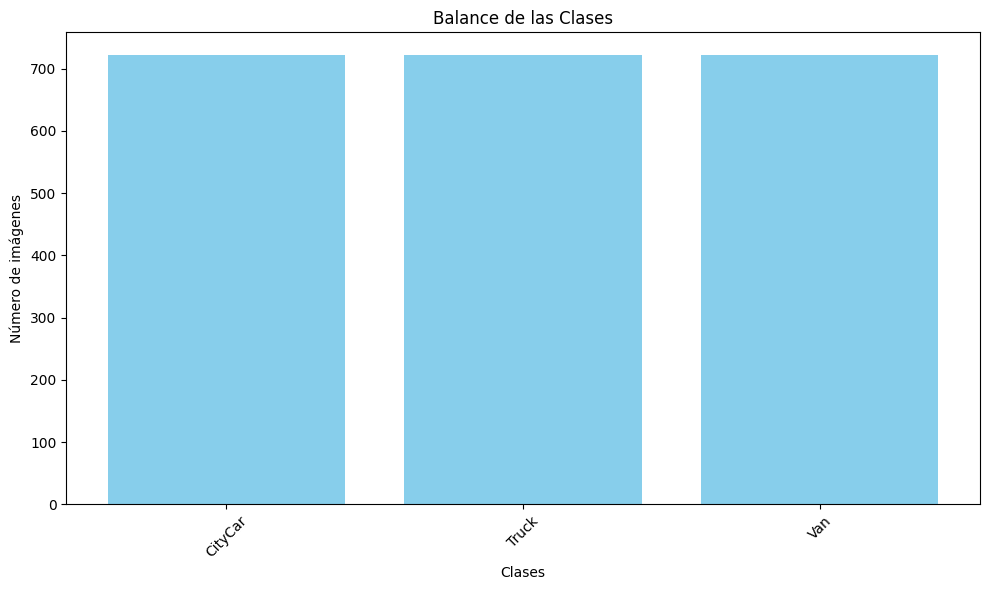

In [93]:
# Llamar a la función para generar el gráfico
graficar_balance_clases(Balanced_Images)